# <a href="https://www.kaggle.com/c/histopathologic-cancer-detection" target="_blank">Histopathologic Cancer-Detection</a>

## Identify metastatic tissue in histopathologic scans of lymph node sections

<img src="images/pcam.png" />
<center>
    <em>Example images from PCam. <a href="#More-samples">See here</a></em>
</center>

## Background

<div style="text-align: justify">

<img src="images/microscope.jpg" height="220" width="260" align="right"/>In this problem, we have to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the <a href="https://github.com/basveeling/pcam">PatchCamelyon (PCam) benchmark dataset</a>. In the author's words:
</div>

> PCam packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and WSI diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty and explainability.

## Data

- Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder.
- Predict the labels for the images in the test folder. 
- A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.
- More details can be found here: https://www.kaggle.com/c/histopathologic-cancer-detection/data

## Evaluation Metrics

Evaluation is based on <a href="http://en.wikipedia.org/wiki/Receiver_operating_characteristic">area under the ROC curve</a> between the predicted probability and the observed target.

> The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection in machine learning. The false-positive rate is also known as the fall-out or probability of false alarm and can be calculated as (1 − specificity).

## Development

We'll use the __fastai__ library for the classification task. More details can be found here:

- [Documentation](http://docs.fast.ai)
- [Github](https://github.com/fastai/fastai)

In [1]:
# Line magics
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import modules
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import random

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

from fastai import *
from fastai.vision import *

In [3]:
# configure path so as to load data
path = Config.data_path()/'cancer'
path

PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer')

In [4]:
# list contents of the directory
path.ls()

[PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/train'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/fastai_cancer_resnet50.csv'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/labels.csv'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/test'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/sample_submission.csv'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/models')]

In [5]:
# list few files in train folder
train_path = path/'train'
fnames = get_image_files(train_path)
fnames[:5]

[PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/train/130ba8b1e99c2e75e9b36a76564bbdc08a5a19f7.tif'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/train/7dc5e4e7b271faa93e32fb3d70a93ba8e51210e3.tif'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/train/37823e9e1d5b746ef25d48a6ac34da5ceb4f31c8.tif'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/train/088ed2cf8484f970f6a52d20f8dd19948f73e12f.tif'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer/train/ae95d19c982bd00d22b093e97c6b7c0d095e9ed3.tif')]

In [6]:
# let's describe labels
data = pd.read_csv(path/'labels.csv')
data.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
id       220025 non-null object
label    220025 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


### Let's look at a sample image

_Note : A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image._ 

torch.Size([96, 96])

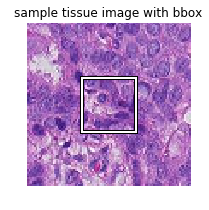

In [8]:
# let's see how one of our training image looks like
img = open_image(train_path/'4c9d40a61b0dcdd3a3fec107e8001d430c74a35c.tif')
bbox = ImageBBox.create(*img.size, [[32, 32, 64, 64]])
img.show(y=bbox, title="sample tissue image with bbox")
img.size

## More samples

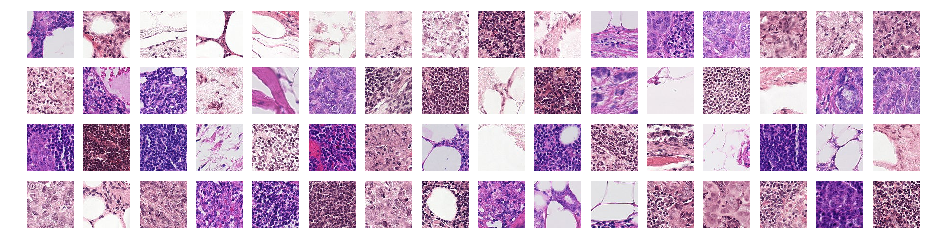

In [9]:
sample_files = random.sample(fnames, 64)

imgs = []
for name in sample_files:
    file_path = os.path.join(train_path, name.parts[-1])
    im = open_image(file_path)
    imgs.append(im)

show_all(imgs,4,16,(16,4))

### Now, let's look more closely at the positive and negative samples

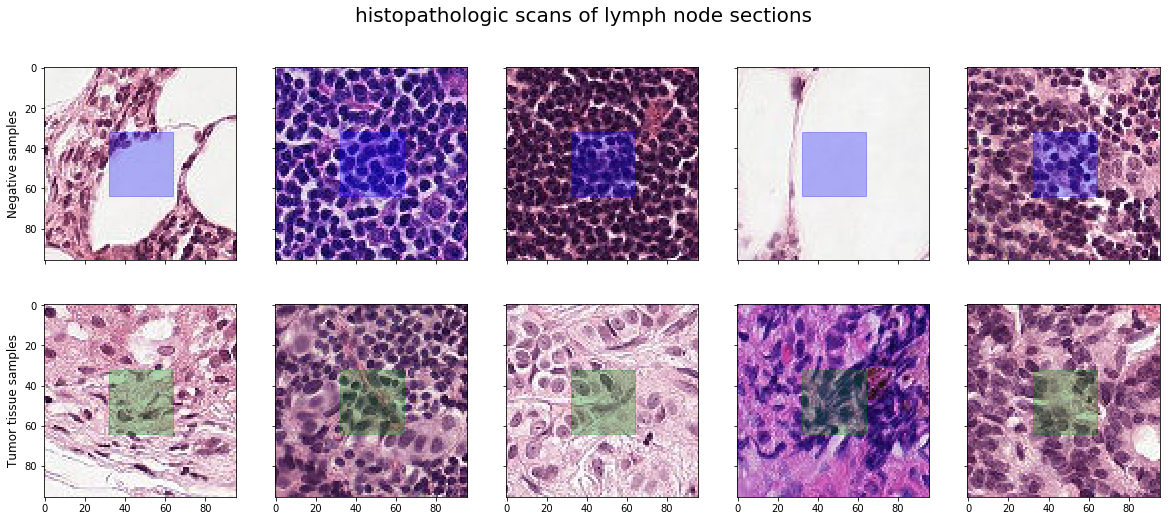

In [10]:
# we'll take some samples from shuffled data and 
# draw a patch on top for positive and negative results
from PIL import Image

shuffled_data = shuffle(data)

fig, ax = plt.subplots(2, 5, figsize=(20,8), sharex='col', sharey='row')
fig.suptitle("histopathologic scans of lymph node sections", fontsize=20)
    
ax[0, 0].set_ylabel('Negative samples', size='large')
ax[1, 0].set_ylabel('Tumor tissue samples', size='large')

# Negative classes
for i, idx in enumerate(shuffled_data[shuffled_data['label']==0]['id'][:5]):
    file_path = os.path.join(train_path, idx)
    im = Image.open(file_path +'.tif')
    ax[0, i].imshow(im)
    bbox = patches.Rectangle((32,32), 32, 32, color='b', alpha=.3, capstyle='round')
    ax[0, i].add_patch(bbox)

# Positive classes
for i, idx in enumerate(shuffled_data[shuffled_data['label']==1]['id'][:5]):
    file_path = os.path.join(train_path, idx)
    im = Image.open(file_path +'.tif')
    ax[1, i].imshow(im)
    rbox = patches.Rectangle((32,32), 32, 32, color='g', alpha=.3, capstyle='round')
    ax[1, i].add_patch(rbox)

### Apply Transforms

```python
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.
```

In [11]:
tfms = get_transforms(flip_vert=True)

In [12]:
def get_ex(): 
    return open_image(train_path/'4c9d40a61b0dcdd3a3fec107e8001d430c74a35c.tif')

def plots_f(rows, cols, width, height, **kwargs):
    bbox = ImageBBox.create(*img.size, [[32, 32, 64, 64]])
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax, y=bbox) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

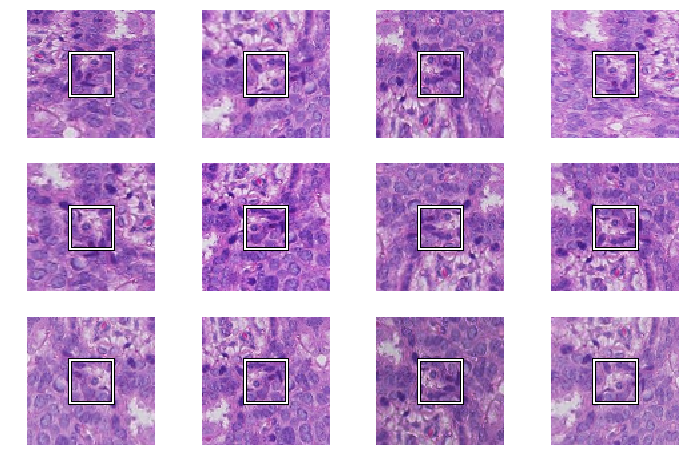

In [13]:
# let's plot a sample image using `tfms` and helper functions defined above
plots_f(3, 4, 12, 8, size=96)

In [14]:
pd.read_csv(path/'labels.csv').head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Create a DataBunch


```python
help(ImageDataBunch.from_csv)

Help on method from_csv in module fastai.vision.data:
    
from_csv(path: Union[pathlib.Path, str], folder: Union[pathlib.Path, str] = '.', sep=None, csv_labels: Union[pathlib.Path, str] = 'labels.csv', valid_pct: float = 0.2, fn_col: int = 0, label_col: int = 1, suffix: str = '', header: Union[int, str, NoneType] = 'infer', **kwargs: Any) -> 'ImageDataBunch' method of builtins.type instance
    Create from a csv file in `path/csv_labels`.
```

In [15]:
# set batch size
bs=32

In [16]:
data = ImageDataBunch.from_csv(path, folder='train', test='test', suffix='.tif', ds_tfms=tfms, bs=bs, size=72)

In [17]:
data.classes

[0, 1]

## Normalize
```python
help(ImageDataBunch.normalize)

Help on function normalize in module fastai.vision.data:

normalize(self, stats: Collection[torch.Tensor] = None, do_x: bool = True, do_y: bool = False) -> None
    Add normalize transform using `stats` (defaults to `DataBunch.batch_stats`)
```

In [18]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 1, Category 0, Category 0, Category 0, Category 0]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 1, Category 0]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/cancer;

Test: LabelList
y: EmptyLabelList (57458 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]

## Let's look at a few images inside a batch
```python
help(ImageDataBunch.show_batch)

Help on function show_batch in module fastai.basic_data:

show_batch(self, rows: int = 5, ds_type: fastai.basic_data.DatasetType = <DatasetType.Train: 1>, **kwargs) -> None
    Show a batch of data in `ds_type` on a few `rows`.
```

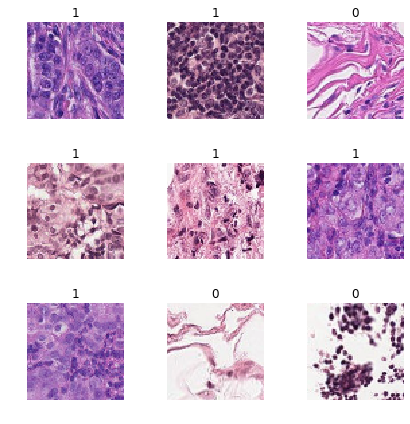

In [19]:
data.show_batch(rows=3, figsize=(6,6), ds_type=DatasetType.Train)

In [20]:
len(data.train_ds)

176020

In [21]:
len(data.valid_ds)

44005

In [22]:
len(data.test_ds)

57458

## Transfer Learning

Transfer learning is a technique where you use a model trained on a very large dataset (usually ImageNet in computer vision) and then adapt it to your own dataset. The idea is that it has learned to recognize many features on all of this data, and that you will benefit from this knowledge, especially if your dataset is small, compared to starting from a randomly initiliazed model.

Then we will train the model we obtain in two phases: first we freeze the body weights and only train the head (to convert those analyzed features into predictions for our own data), then we unfreeze the layers of the backbone (gradually if necessary) and fine-tune the whole model (possily using differential learning rates).

The create_cnn factory method helps you to automatically get a pretrained model from a given architecture with a custom head that is suitable for your data.

More details here : [Transfer learning](https://docs.fast.ai/vision.learner.html#Transfer-learning)
```python
help(create_cnn)

Help on function create_cnn in module fastai.vision.learner:

create_cnn(data: fastai.basic_data.DataBunch, arch: Callable, cut: Union[int, Callable] = None, pretrained: bool = True, lin_ftrs: Union[Collection[int], NoneType] = None, ps: Union[float, Collection[float]] = 0.5, custom_head: Union[torch.nn.modules.module.Module, NoneType] = None, split_on: Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType] = None, bn_final: bool = False, **kwargs: Any) -> fastai.basic_train.Learner
    Build convnet style learners
```

In [23]:
# We'll create our learner object with the DataBunch created above and using resnet34 backbone/arch.
# Additionally, we can also specify metrics to see the progress of our learning task
learn = create_cnn(data, models.resnet50, metrics=accuracy)

In [24]:
# This is what our leaner looks like. More on this in a later post.
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [25]:
# First let's look at what a good LR might look like
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


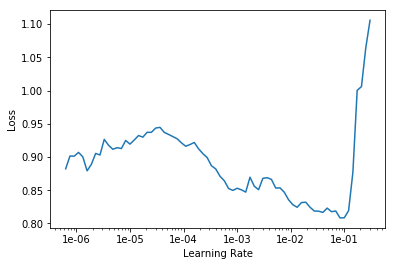

In [26]:
# plot loss vs. lr
learn.recorder.plot()

## fit_one_cycle
```python
help(fit_one_cycle)

Help on function fit_one_cycle in module fastai.train:

fit_one_cycle(learn: fastai.basic_train.Learner, cyc_len: int, max_lr: Union[float, Collection[float], slice] = slice(None, 0.003, None), moms: Tuple[float, float] = (0.95, 0.85), div_factor: float = 25.0, pct_start: float = 0.3, wd: float = None, callbacks: Union[Collection[fastai.callback.Callback], NoneType] = None, **kwargs) -> None
    Fit a model following the 1cycle policy.
```

In [27]:
# Now let's train our model and see how the train_loss, valid_loss, and accuracy changes over each epoch.
# We'll use fit_one_cycle() to fit a model using 1cycle policy.
# An epoch means a complete run through our training data. We'll do 4 runs here.
learn.fit_one_cycle(4, max_lr=(1e-4, 1e-3, 1e-2), wd=(1e-4, 1e-4, 1e-1))

epoch,train_loss,valid_loss,accuracy
1,0.310550,0.233305,0.908170
2,0.256942,0.206569,0.920759
3,0.226722,0.183511,0.930394
4,0.226037,0.166718,0.937712


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
# Once we have run fit_one_cycle, the final weights of our trained model can be saved for later use.
learn.save('stage-1')

## Classification Interpretation

In [29]:
# This provides a confusion matrix and visualization of the most incorrect images. 
# You can pass your data, calculated predictions, actual y_val, and your losses, and view the model interpretation results.
interp = ClassificationInterpretation.from_learner(learn)

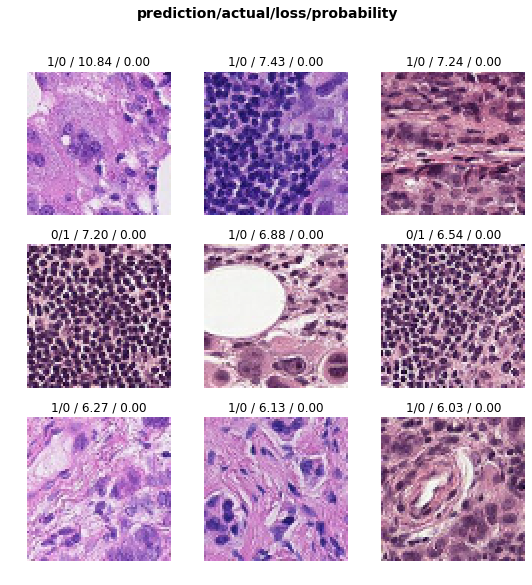

In [30]:
# Plot top losses (images)
interp.plot_top_losses(9, figsize=(9,9))

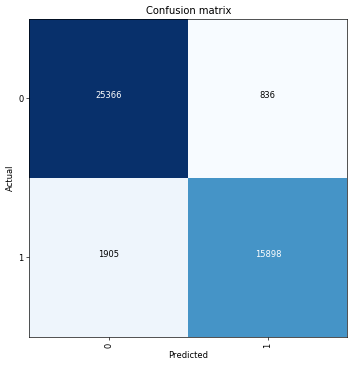

In [31]:
# Plot confusion matrix
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [32]:
conf_matrix = interp.confusion_matrix()
conf_matrix

array([[25366,   836],
       [ 1905, 15898]])

In [33]:
tn, fp, fn, tp = conf_matrix.item(0), conf_matrix.item(1), conf_matrix.item(2), conf_matrix.item(3)
tp, fp, fn, tn

(15898, 836, 1905, 25366)

In [34]:
total = tp + fp + fn + tn
accur = (tp+tn)/total
accur

0.9377116236791274

In [35]:
# Unfreeze entire model. https://docs.fast.ai/basic_train.html#Learner.unfreeze
learn.unfreeze()

In [36]:
# fit one cycle after unfreezing all layers
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy
1,0.286818,0.230216,0.914532
2,0.224357,0.172036,0.937325
3,0.172776,0.139883,0.950642
4,0.143839,0.127820,0.955346


In [37]:
# if accuracy looks ok, save final learner weights and use it to predict on test data set.
learn.save('stage_2')

In [38]:
# try predicting on a sample test image
img = learn.data.test_ds[0][0]
learn.predict(img)

(Category 0, tensor(0), tensor([0.9934, 0.0066]))

In [39]:
# https://docs.fast.ai/basic_train.html#Test-time-augmentation
preds_t = learn.TTA(ds_type=DatasetType.Test)

In [40]:
# each predictions give probabilty/chance of belonging to pos/neg class for all the test set images.
preds_t[0].shape

torch.Size([57458, 2])

## Acknowledgements

With this I would like to conclude this post. 

I would like to thank [Jeremy Howard](https://www.fast.ai/about/#jeremy) and [Rachel Thomas](https://www.fast.ai/about/#rachel) for sharing your knowledge and intuitions about deep learning. More inner level details and math ideas could be found in the references. If you liked my post, please do share them with others.

## References:

### Deep Learning References:
- [Practical Deep Learning For Coders v3 by Jeremy Howard](http://fast.ai) (will be publicly available in early this year)
- [Radek Osmulski's blog](https://medium.com/@radekosmulski)
- [Sylvain Gugger's blog](https://sgugger.github.io/)
- [Marvin Petersen's blog](https://vinpetersen.github.io/) for guided tour on CNNs

### Other:
- [Kaggle Competition](https://kaggle.com/c/histopathologic-cancer-detection)
- [PCAM](http://basveeling.nl/posts/pcam/)